# Problem set 10

## Name: Baite Pang

## Link to your PS10 github repo: 

### Problem 0 

-2 points for every missing green OK sign. 

Make sure you are in the DATA1030 environment.

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.12.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.12.10"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.12.10"):
    print(FAIL, "Python version 3.12.10 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "2.2.5", 'matplotlib': "3.10.1",'sklearn': "1.6.1", 
                'pandas': "2.2.3",'xgboost': "3.0.0", 'shap': "0.47.2", 
                'polars': "1.27.1", 'seaborn': "0.13.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.12.10

[ OK ] numpy version 2.2.5 is installed.
[ OK ] matplotlib version 3.10.1 is installed.
[ OK ] sklearn version 1.6.1 is installed.
[ OK ] pandas version 2.2.3 is installed.
[ OK ] xgboost version 3.0.0 is installed.
[ OK ] shap version 0.47.2 is installed.
[ OK ] polars version 1.27.1 is installed.
[ OK ] seaborn version 0.13.2 is installed.


## Description

In this problem set you will use the kaggle house price dataset to work through a couple of different feature importance metrics. We provide you with code that trains an XGBoost regression model. You should not need to edit any of the below code, but look through it to make sure you understand what's going on. 

The main take-away from this problem set is that feature importance is not easy to measure and it depends strongly on what metric you use. 

In [21]:
# read the data
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy  as np
from sklearn.model_selection import train_test_split

# Let's load the data
path = Path.home() / "Documents" / "data1030-fall2025" / "data" / "train_11.csv"
df = pd.read_csv(path)
# drop the ID
df.drop(columns=['Id'],inplace=True)

# the target variable
y = df['SalePrice']
df.drop(columns=['SalePrice'],inplace=True)
# the unprocessed feature matrix
X = df.values
print(f'feature matrix size: {X.shape}')
# the feature names
ftrs = df.columns

feature matrix size: (1460, 79)


In [22]:
# let's split to train, CV, and test
X_other, X_test, y_other, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=0)

print(f'train size: {X_train.shape}')
print(f'validation size: {X_CV.shape}')
print(f'test size: {X_test.shape}')

train size: (876, 79)
validation size: (292, 79)
test size: (292, 79)


In [23]:
# collect the various features
cat_ftrs = ['MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood','Condition1','Condition2',\
            'BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',\
           'Heating','CentralAir','Electrical','GarageType','PavedDrive','MiscFeature','SaleType','SaleCondition']
ordinal_ftrs = ['LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',\
               'BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish',\
               'GarageQual','GarageCond','PoolQC','Fence']
ordinal_cats = [['Reg','IR1','IR2','IR3'],['AllPub','NoSewr','NoSeWa','ELO'],['Gtl','Mod','Sev'],\
               ['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Po','Fa','TA','Gd','Ex'],['NA','No','Mn','Av','Gd'],['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],\
               ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],\
               ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Unf','RFn','Fin'],['NA','Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],
               ['NA','Fa','TA','Gd','Ex'],['NA','MnWw','GdWo','MnPrv','GdPrv']]
num_ftrs = ['MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd',\
             'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',\
             'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',\
             'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF',\
             'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']

In [24]:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [25]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# little hacky, but collect feature names
feature_names = preprocessor.get_feature_names_out()

df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(f'preprocessed train size: {df_train.shape}')

# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
print(f'preprocessed validation size: {df_CV.shape}')

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(f'preprocessed test size: {df_test.shape}')

preprocessed train size: (876, 220)
preprocessed validation size: (292, 220)
preprocessed test size: (292, 220)


In [26]:
# import necessary libraries for xgboost 
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# parameters to try 
param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              "missing": [np.nan], 
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

# create xgboost model and set parameters 
XGB = xgboost.XGBRegressor(early_stopping_rounds=50)
XGB.set_params(**ParameterGrid(param_grid)[0])

# fit model to train data 
XGB.fit(df_train,y_train,eval_set=[(df_CV, y_CV)], verbose=False)

# predict on validation 
y_CV_pred = XGB.predict(df_CV)
print('the CV RMSE:',np.sqrt(mean_squared_error(y_CV,y_CV_pred)))

# predict on test 
y_test_pred = XGB.predict(df_test)
print('the test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))
print('the test R2:',r2_score(y_test,y_test_pred))

the CV RMSE: 24584.178326720623
the test RMSE: 33324.32624975335
the test R2: 0.8391927480697632


## Problem 1 (5 points)

Calculate the perturbation feature importance values on the test set and visualize the results. This dataset has many features so show only the top 10 most important ones on the figure. You can use the code from the lecture notes or work with sklearn's [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html).

,feature,importance_mean,importance_std
0,num__OverallQual,0.216996,0.018925
1,num__GrLivArea,0.127615,0.008906
2,num__BsmtFinSF1,0.025996,0.003296
3,num__TotalBsmtSF,0.022397,0.003835
4,num__TotRmsAbvGrd,0.009793,0.001651
5,num__1stFlrSF,0.008597,0.003962
6,num__GarageCars,0.006765,0.001087
7,num__YearBuilt,0.005967,0.002063
8,num__LotArea,0.004971,0.003197
9,num__OverallCond,0.003927,0.001457


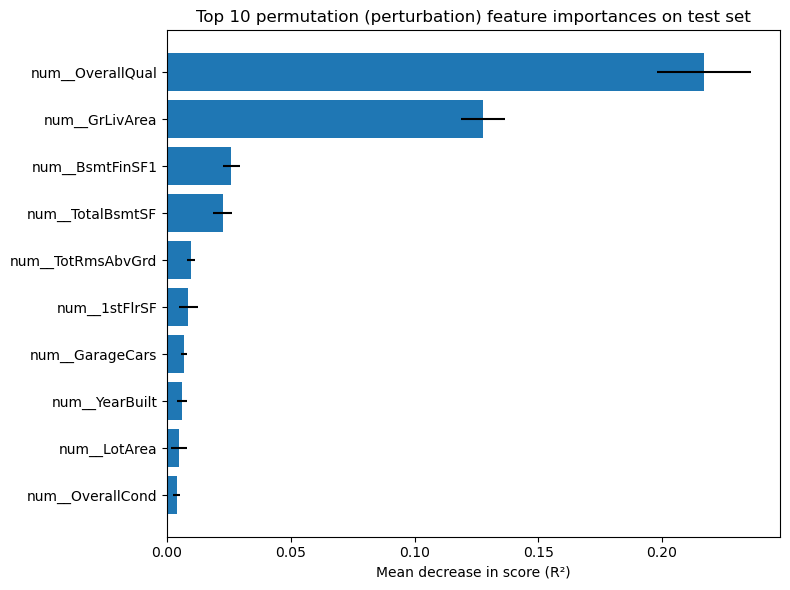

In [27]:
# your code here
from sklearn.inspection import permutation_importance

perm_result = permutation_importance(
    XGB,           # fitted XGBoost model
    df_test,       # preprocessed test features
    y_test,        # true test targets
    n_repeats=10,  # number of permutations per feature
    random_state=0,
    n_jobs=-1
)

importances_mean = perm_result.importances_mean
importances_std  = perm_result.importances_std

# Get indices of the top 10 most important features
idx_sorted = np.argsort(importances_mean)[::-1][:10]

top_features   = df_test.columns[idx_sorted]
top_importance = importances_mean[idx_sorted]
top_std        = importances_std[idx_sorted]

display(pd.DataFrame({
    "feature": top_features,
    "importance_mean": top_importance,
    "importance_std": top_std
}))

# Plot the top 10 permutation importances
plt.figure(figsize=(8, 6))
# Plot reversed so the most important feature is at the top
plt.barh(range(len(top_features)), top_importance[::-1], xerr=top_std[::-1])
plt.yticks(range(len(top_features)), top_features[::-1])
plt.xlabel("Mean decrease in score (R²)")
plt.title("Top 10 permutation (perturbation) feature importances on test set")
plt.tight_layout()
plt.show()


## Problem 2 (10 points)

As we discussed in class, XGBoost implements 5 different metrics to measure feature importance. Calculate all 5 metrics and create 5 figures showing the top 10 most important features for each metric.

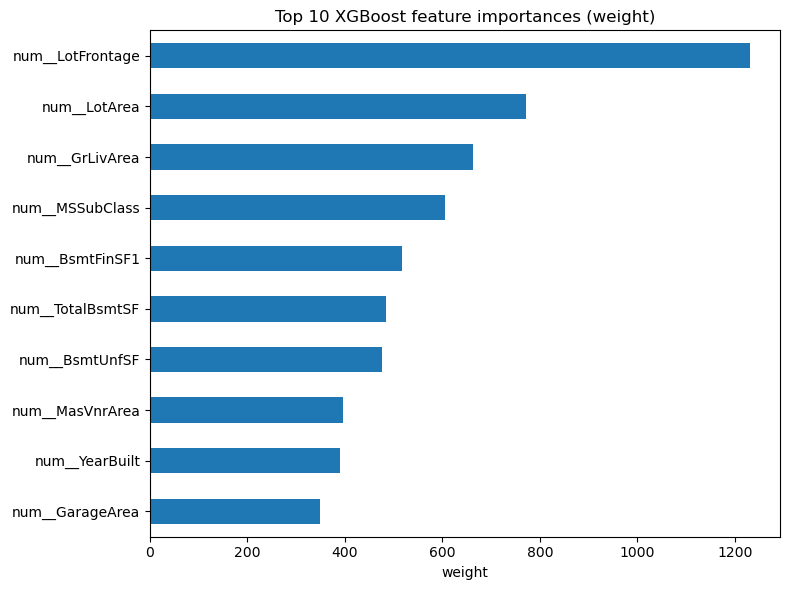

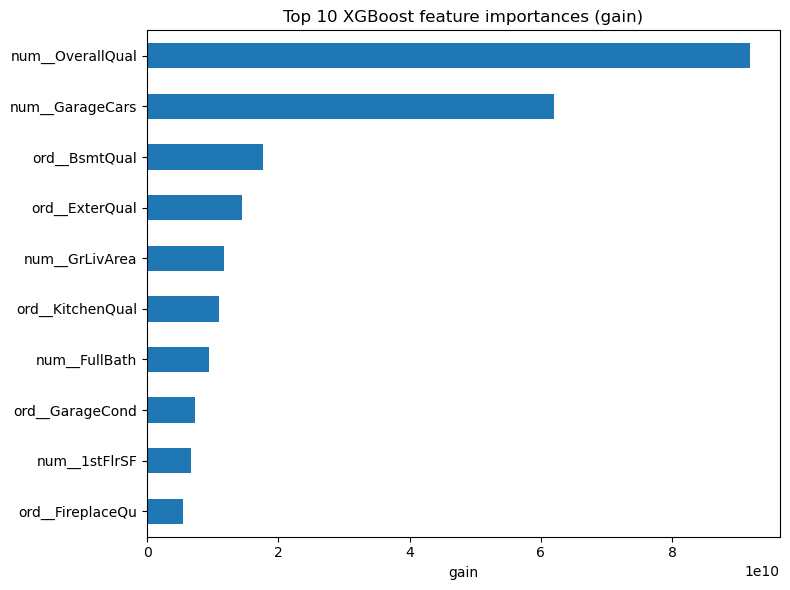

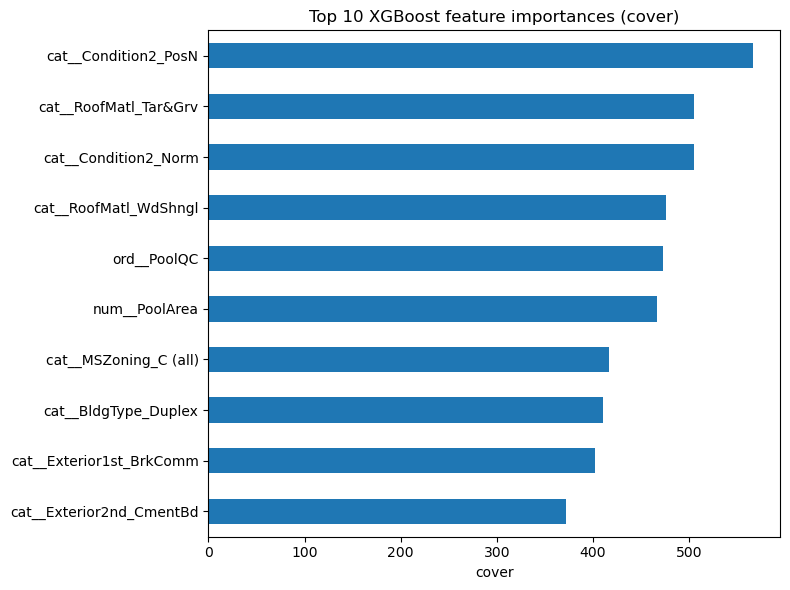

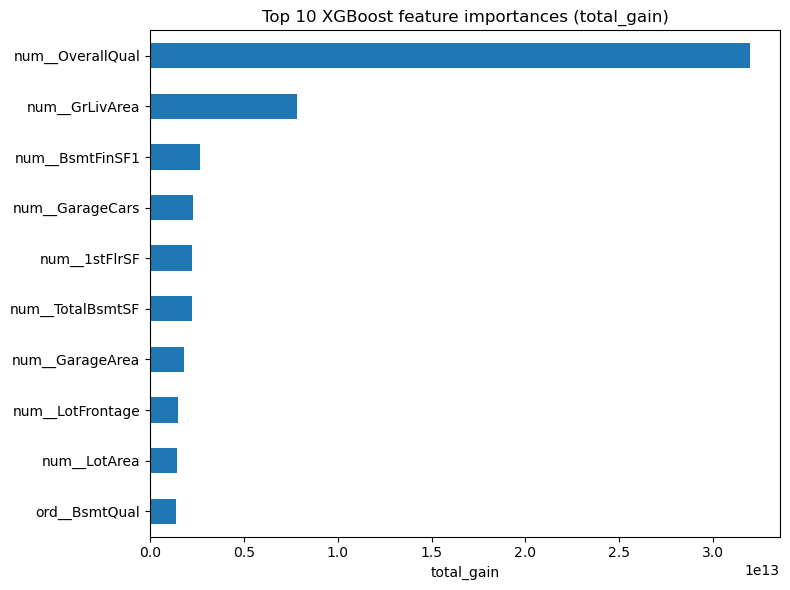

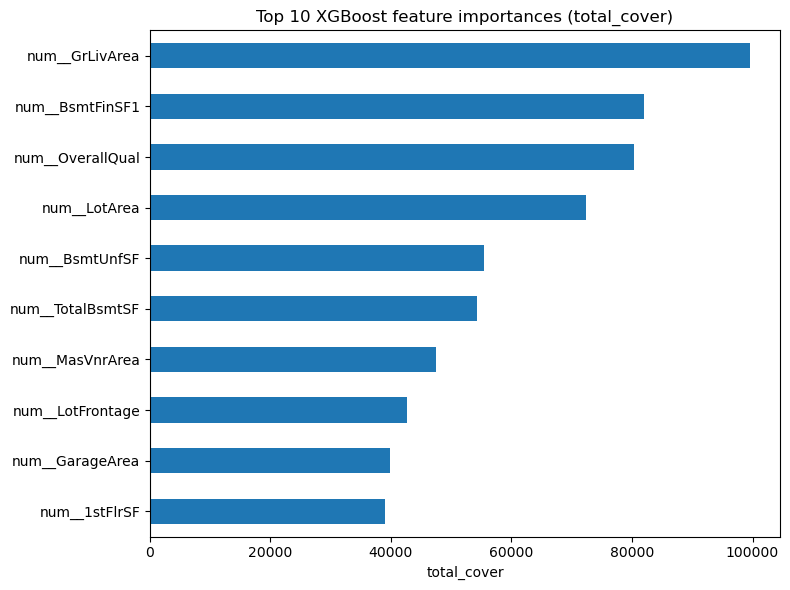

In [28]:
import matplotlib.pyplot as plt

booster = XGB.get_booster()

importance_types = ["weight", "gain", "cover", "total_gain", "total_cover"]

# Helper: map XGBoost's feature names ("f0", "f1", ...) to your df_train columns
def pretty_name(feat_name):
    # If XGBoost kept the actual column names, just return as-is
    if feat_name in df_train.columns:
        return feat_name
    
    # Otherwise, map "f0" -> df_train.columns[0], etc.
    if feat_name.startswith("f") and feat_name[1:].isdigit():
        idx = int(feat_name[1:])
        return df_train.columns[idx]
    
    # Fallback
    return feat_name

for imp_type in importance_types:
    # Get importance dict: {feature_name: importance_value}
    score_dict = booster.get_score(importance_type=imp_type)
    
    # Convert to a Series
    importances = pd.Series(score_dict, dtype=float)
    
    # Map feature names to human-readable column names
    importances.index = [pretty_name(f) for f in importances.index]
    
    # Sort and keep top 10
    top_importances = importances.sort_values(ascending=False).head(10)
    
    # Plot
    plt.figure(figsize=(8, 6))
    top_importances.iloc[::-1].plot(kind="barh")  # reverse so largest is on top
    plt.xlabel(imp_type)
    plt.title(f"Top 10 XGBoost feature importances ({imp_type})")
    plt.tight_layout()
    plt.show()


## Problem 3a (10 points)

Let's now calculate the shap values of the test set points. Use the shap values to calculate global feature importance values and prepare a plot that shows the top 10 most important features. Choose one of the two approaches:

1) You can use the shap package as we did in class. You will encounter an error which you'll need to solve yourself. Please do not ask about this error on Ed Discussion. Instead, figure it out yourself. You'll also need to manually change some parameters of the plot.

2) XGBoost can directly calculate shap values for you (look up how) but you need to recreate the figures with matplotlib because XGBoost's shap values don't come with visualizations. 

Both approaches take roughly the same amount of time to work through. 

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

shap.initjs()

# TreeExplainer for tree-based models like XGBoost
explainer = shap.TreeExplainer(XGB)

# SHAP values for the test set
# shap_values has shape (n_test_samples, n_features)
shap_values = explainer.shap_values(df_test)

print("shap_values shape:", np.array(shap_values).shape)


shap_values shape: (292, 220)


In [31]:
# Convert to numpy array in case it's not already
shap_values_arr = np.array(shap_values)

# Mean |SHAP| across samples → global importance for each feature
mean_abs_shap = np.abs(shap_values_arr).mean(axis=0)   # shape: (n_features,)

# Put into a Series indexed by feature names
shap_importance = pd.Series(mean_abs_shap, index=df_test.columns)

# Top 10 most important features
top10 = shap_importance.sort_values(ascending=False).head(10)

display(pd.DataFrame({
    "feature": top10.index,
    "mean_abs_SHAP": top10.values
}))


,feature,mean_abs_SHAP
0,num__OverallQual,26782.359375
1,num__GrLivArea,14527.018555
2,num__TotalBsmtSF,5516.351562
3,num__BsmtFinSF1,4198.355957
4,num__LotArea,3465.658447
5,ord__BsmtQual,3464.082275
6,num__1stFlrSF,3198.603516
7,num__GarageArea,2946.145996
8,ord__KitchenQual,2907.585938
9,num__YearBuilt,2728.212402


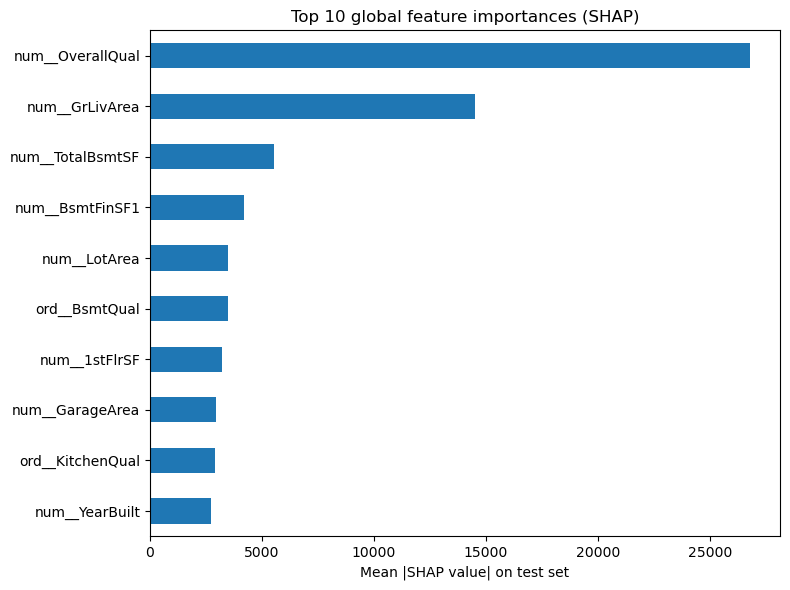

In [32]:
plt.figure(figsize=(8, 6))
top10.iloc[::-1].plot(kind="barh")  # reverse to show largest at the top
plt.xlabel("Mean |SHAP value| on test set")
plt.title("Top 10 global feature importances (SHAP)")
plt.tight_layout()
plt.show()


## Problem 3b (10 points)

Let's take a look at some specific data points with indices 0, 100, and 200. For each data point, create a force plot and describe in a paragraph or two which features contribute positively and negatively to the prediction.

In [ ]:
from IPython.display import display, HTML

shap_vals = np.array(shap_values) 
base_value = explainer.expected_value
if isinstance(base_value, np.ndarray):
    base_value = base_value[0]

def show_force_or_bar(idx):
    try:
        display(HTML(f"<h3>Index {idx} — interactive force plot</h3>"))
        force = shap.force_plot(base_value, shap_vals[idx], df_test.iloc[idx])
        display(force)
    except Exception as e:
        sv = pd.Series(shap_vals[idx], index=df_test.columns)
        top = sv.abs().sort_values(ascending=False).head(10)
        top_names = top.index
        vals = sv[top_names]
        colors = ['red' if v>0 else 'blue' for v in vals]
        plt.figure(figsize=(8,6))
        vals[::-1].plot(kind='barh', color=colors[::-1])
        plt.xlabel("SHAP value (positive increases prediction)")
        plt.title(f"Top 10 SHAP contributors for index {idx} (static fallback)")
        plt.tight_layout()
        plt.show()

def describe_point(idx, n=5):
    """Print the top n positive and negative feature contributors by SHAP value."""
    sv = pd.Series(shap_vals[idx], index=df_test.columns)
    pos = sv[sv>0].sort_values(ascending=False).head(n)
    neg = sv[sv<0].sort_values().head(n)
    print(f"Index {idx} — base value (expected): {base_value:.2f}")
    print("\nTop positive contributors (increase prediction):")
    display(pos.to_frame(name="SHAP value"))
    print("\nTop negative contributors (decrease prediction):")
    display(neg.to_frame(name="SHAP value"))

for i in [0, 100, 200]:
    show_force_or_bar(i)
    describe_point(i, n=7)

Index 0 — base value (expected): 180975.47

Top positive contributors (increase prediction):


,SHAP value
num__GrLivArea,40663.679688
num__TotalBsmtSF,16107.137695
num__LotArea,15517.151367
num__BsmtFinSF1,8843.585938
num__1stFlrSF,3460.430664
ord__FireplaceQu,2972.952881
num__FullBath,2836.094482



Top negative contributors (decrease prediction):


,SHAP value
num__OverallQual,-18416.365234
num__OverallCond,-8121.550781
ord__KitchenQual,-6041.037109
ord__BsmtQual,-5731.327637
num__OpenPorchSF,-2918.576660
ord__Functional,-2633.976318
ord__BsmtFinType1,-2273.041748


Index 100 — base value (expected): 180975.47

Top positive contributors (increase prediction):


,SHAP value
num__BsmtFinSF1,16994.626953
num__OverallQual,16197.923828
num__TotalBsmtSF,10185.553711
num__1stFlrSF,9327.114258
num__GrLivArea,6324.020996
ord__KitchenQual,5248.730957
ord__BsmtQual,4881.375977



Top negative contributors (decrease prediction):


,SHAP value
num__OpenPorchSF,-2069.707764
num__MoSold,-1928.797607
ord__FireplaceQu,-1388.743896
num__OverallCond,-987.756836
num__2ndFlrSF,-737.993530
cat__Neighborhood_CollgCr,-661.314880
num__Fireplaces,-649.882263


Index 200 — base value (expected): 180975.47

Top positive contributors (increase prediction):


,SHAP value
cat__Exterior1st_BrkFace,4103.519043
num__OverallCond,1852.722290
num__TotalBsmtSF,807.678894
num__1stFlrSF,624.823853
num__MoSold,618.385864
ord__GarageCond,369.463806
cat__MSZoning_RM,256.896027



Top negative contributors (decrease prediction):


,SHAP value
num__OverallQual,-23110.082031
num__GrLivArea,-4530.296387
cat__SaleCondition_Abnorml,-4371.663574
ord__BsmtQual,-4298.621094
num__GarageCars,-2733.544434
num__GarageArea,-2607.413818
ord__KitchenQual,-2534.443359


**your explanation here**

show_force_or_bar tries to create an interactive SHAP force plot for a single test observation, showing how each feature’s SHAP value pushes the prediction up (positive) or down (negative) from the base value. If the interactive plot fails (e.g., due to a JS/rendering error), it falls back to a static horizontal bar chart of the top 10 features for that point, coloring positive SHAP values red and negative ones blue.

describe_point prints a small table of the top n most positive and most negative SHAP values for that same observation, so you can see numerically which features increase and decrease the prediction the most.

The final for loop runs both functions for indices 0, 100, and 200, so you get a visualization plus a ranked list of important features for each of those three data points.

## Problem 4 (5 points)

You calculated 7 different global feature importance metrics (perturbation, 5 XGB metrics, global shap). Unfortunately the ranking of features can be quite different depending on the importance metric used. Write a short discussion on the similarities and differences amongst the 7 methods. Are there features that tend to be in the top 3-5 regardless of the approach used? Discuss the pros and cons of the various approaches!

**your explanation here**

Similarities: GrLivArea, OverallQual, and TotalBsmtSF consistently rank in top 5 across most methods, suggesting these are truly important predictors. Size-related features (living area, basement) and quality measures dominate regardless of metric.

Differences: XGBoost weight favors frequently-used features, while gain/totalgain emphasize actual predictive power. Permutation importance is modelagnostic but computationally expensive. SHAP provides both global and local interpretability with theoretical guarantees.

Pros/Cons:  XGB metrics: Fast, builtin, but modelspecific and can be misleading (weight not equal to importance) - Permutation: Model-agnostic, intuitive, but slow and can be unstable - SHAP: Theoretically grounded, local explanations, but complex and computationally intensive

## Interesting Note (no points, just for reading purposes)

You've probably noticed that, when working with SHAP on XGBoost, you can use either the model-agnostic "Explainer" or the tree-specific "Tree-Explainer". If you rememeber the math from class, this might be confusing: nowhere does the formula assume you're working with a tree, so why should SHAP care about the model you're working with?

The reason for this is **speed**. Recall that the formula for SHAP values is: $\Phi_i = \sum_{S\subseteq M\setminus i}  \frac{|S|!(M - |S| - 1)!} {M!} [f_x(S\cup i) - f_x(S)]$, where: 

- $\Phi_i$ - the contribution of feature $i$
- $M$ - the number of features
- $S$ - a set of features excluding $i$, a vector of 0s and 1s (0 if a feature is missing)
- $|S|$ - the number of features in $S$
- $f_x(S)$ - the prediction of the model with features $S$

For a tree-based method, calculating SHAP values with this method takes $O(TL2^M)$ time, with T = the number of trees, L = the max number of leaves in a tree, and M = the number of features. This is **extremely slow**, especially as M increases. 

However, in a [2018 paper](https://arxiv.org/abs/1802.03888), researchers developed a new strategy specifically for trees that runs in $O(TLD^2)$, with D the maximum depth of any tree. Notice: this new method **does not rely on the number of features**. Due to this exponential speed-up, SHAP values have become increasingly popular for explaining tree-based methods.